Version info
>v011 - deleted testing codes

>v013 - manipulating multiple beta

>v014 - Handling missing data

>v015 - Error fixing of v014

Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

import pymc3 as pm
import scipy.optimize as so

import datetime as dt

import theano
theano.config.compute_test_value = 'raise'

Using gpu device 0: GeForce GTX 750 (CNMeM is disabled)


Debuging option

In [2]:
debug = False

In [3]:
debug = True

Loading and preprocessing barley data(explatory variables)

In [4]:
#Loading data file
#barley_raw = pd.read_csv('./data/barley_01.csv', sep=',', header=0, index_col=0)
barley_raw = pd.read_table('./data/barley_01.txt', sep='\t', header=0, index_col=0)

#Explorering data
if debug:
    barley_raw.head()
    barley_raw.info()

#Transposing
barley_t = barley_raw.transpose()
if debug:
    print(barley_t.iloc[0:5, 0:5])

# 39, 96, 116, 103 th DH lines removed for marker mapping(146 marker mappings)
# and also 33 th DH line should be removed for QTL analysis(145 lines)
barley = barley_t.drop(labels=barley_t.index[[39-1, 96-1, 116-1, 103-1, 33-1]])

barley.head()

#Imputed missing(-) to 1 temporarily, I'll use automatic imputation feature of PyMC
#[http://stronginference.com/missing-data-imputation.html]
#barley.replace(['A', 'B', '-'], [0,1,1], inplace=True)
barley.replace(['A', 'B', '-'], [0,1,-999], inplace=True)
#barley.replace(['A', 'B', '-'], [0,1,1], inplace=True)

barley_arr = np.array(barley)

if debug:
    print(barley.ix[:6,10:20])

<class 'pandas.core.frame.DataFrame'>
Index: 127 entries, *dRpg1 to *MWG632
Columns: 150 entries, 1 to 150
dtypes: object(150)
memory usage: 149.8+ KB
  *dRpg1 *iPgd1A *BCD129 *iEst5 *Prx1A
1      B       B       B      B      B
2      A       A       A      A      A
3      A       A       A      A      A
4      A       A       A      A      A
5      A       A       A      A      A
   *MWG511  *MWG626  *VAtp57A  *MWG571D  *MWG889B  *ABC310B  *PSR129  *ABC253  \
1        1        0         0         0         0         0        0        1   
2        1        1         1         1         1         1     -999        1   
3        0        0         0         0         1      -999        1        1   
4        1     -999         1         1         1         1        1        1   
5        1        1         0         0         0         1        1        1   
6        1        1         1         1         1      -999        1        1   

   *ABG608  *WG380A  
1        1        1  
2  

Extracting data from dataframe with syntax likes R

In [5]:
barley.ix[:2,15:20]

*ABC310B  *PSR129  *ABC253  *ABG608  *WG380A
1         0        0        1        1        1
2         1     -999        1        1        1

Masking missing data that is '-999'

In [6]:
barley_arr_masked = np.ma.masked_array(barley_arr, mask=barley_arr==-999)
barley_arr_masked[:5,15:20]
#help(np.ma.masked_array)

masked_array(data =
 [[0 0 1 1 1]
 [1 -- 1 1 1]
 [-- 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]],
             mask =
 [[False False False False False]
 [False  True False False False]
 [ True False False False False]
 [False False False False False]
 [False False False False False]],
       fill_value = 999999)

Loading and preprocessing heading data(response variable)

In [7]:
heading_raw = pd.read_table('./data/HED_01.txt', sep='\t', header=0, index_col=0)
heading_raw.replace([-9999.0, -9999], [float('NaN'), float('NaN')], inplace=True)
if debug:
    print(heading_raw.head())
    
# Averaging 'days to heading' over all environments for each line.
heading = heading_raw.mean(skipna=True)
if debug:
    heading.head()



                  1   2   3     4   5     6     7   8     9    10  ...    141  \
*AK93~plm3~1   56.5  54  59  54.5  55  54.5  55.5  55  55.5  54.5  ...   57.5   
*OR92~osu2~2    NaN NaN NaN  94.0 NaN   NaN  97.0  94   NaN   NaN  ...    NaN   
*WA92~wsu2~3    NaN NaN NaN  78.0 NaN   NaN  78.0  76   NaN   NaN  ...    NaN   
*WA93~wsu3~4   57.0  57  59  56.0  58  58.0  58.0  56  58.0  56.0  ...   57.0   
*AB92b~ap12~6  65.0  67  64  65.0  64  66.0  67.0  67  67.0  65.0  ...   64.0   

               142  143  144   145  146   147   148  149   150  
*AK93~plm3~1    56   53   54  53.5   55  55.5  54.5   53  55.5  
*OR92~osu2~2    94   94  NaN  94.0   94   NaN   NaN  NaN  94.0  
*WA92~wsu2~3    76   75  NaN  77.0   76   NaN   NaN  NaN  74.0  
*WA93~wsu3~4    57   56   58  57.0   57  57.0  59.0   56  57.0  
*AB92b~ap12~6   64   63   64  64.0   64  65.0  66.0   65  64.0  

[5 rows x 145 columns]


Tried to test run the model with data of masked_array, but it's keep fails. What is the problem?

In [8]:
num_n = 5 #max 144(total 145 rows)
num_p = 2  #max 126(total 127 columns)
#X = barley.ix[:num_n,:num_p]
Y = heading.ix[:num_n]
X = barley_arr_masked[:num_n,:num_p]


niter = 1000
beta = np.empty(num_p, dtype=object)
basic_model = pm.Model()
with basic_model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=100, shape=1) # Intercept
    for i in range(num_p): # beta0 to betaN
        beta[i] = pm.Normal('beta' + str(i), mu=0, sd=100, shape=1)
    sigma = pm.Uniform('sigma', lower=0, upper=20) # Std
    
    # Imput missing values
    # ???
    # refer to [https://github.com/pymc-devs/pymc3/blob/58f3f8e5d2a55edc5e05b33b239fa46631eff895/pymc3/examples/lasso_missing.py]
    
    # Expected value of outcome
    mu = alpha
    for i in range(num_p):
        mu = mu + beta[i]*X[:,i]
    
    # Likelihood
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=Y)
    
    # Obtaining starting values via MAP
    start = pm.find_MAP()
    
    # Draw samples from posterior
    trace = pm.sample(niter, start=start, random_seed=2015, progressbar=True)
    
    # Ploting samples
    pm.traceplot(trace)
    
    # Test code to check if procedure finished.
    print(dt.datetime.now().time())



AssertionError: 

First, I'v suspected the imputation process

to check if there is problem in the imputation process I'v created test data having missing value.

In [9]:
num_n = 6 #max 144(total 145 rows)
num_p = 2  #max 126(total 127 columns)
Y = np.array([10, 9, 8, 1, 2, 1])
X = np.array([[1,1],[1,0],[1,1],[0,0],[0,1],[-999,0]])
X_masked = np.ma.masked_array(X, mask=X==-999)


I'v thought that there will be problem in the imputation process, but this works with no problem.

Assigned <class 'pymc3.step_methods.nuts.NUTS'> to alpha
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta0
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta1
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to sigma_interval
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to p_imp_logodds
Assigned <class 'pymc3.step_methods.metropolis.Metropolis'> to X_imp_missing
 [-----------------100%-----------------] 1000 of 1000 complete in 0.9 sec23:36:38.861534


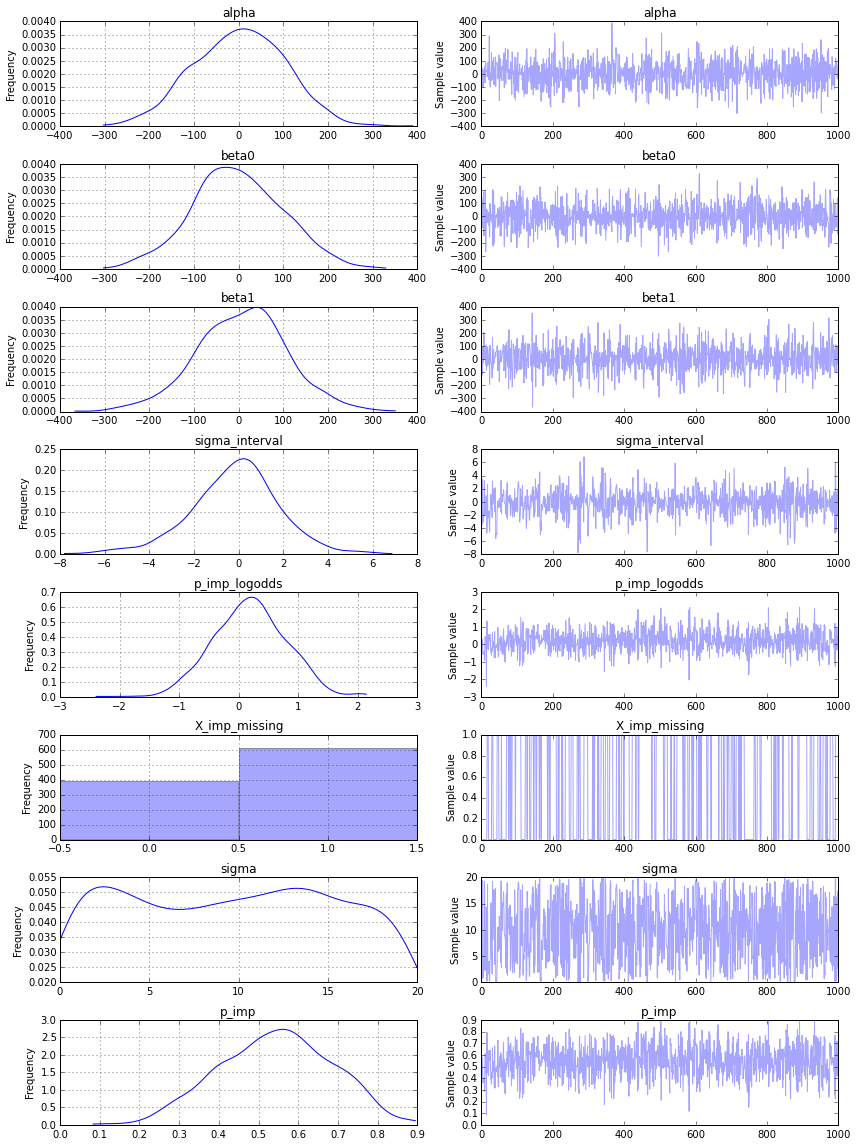

In [10]:

niter = 1000
beta = np.empty(num_p, dtype=object)
#X_imp = np.empty(num_p, dtype=object)
basic_model = pm.Model()
with basic_model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=100, shape=1) # Intercept
    for i in range(num_p): # beta0 to betaN
        beta[i] = pm.Normal('beta' + str(i), mu=0, sd=100, shape=1)
    sigma = pm.Uniform('sigma', lower=0, upper=20) # Std
    
    # Imput missing values
    # ???
    # refer to [https://github.com/pymc-devs/pymc3/blob/58f3f8e5d2a55edc5e05b33b239fa46631eff895/pymc3/examples/lasso_missing.py]
    p_imp = pm.Beta('p_imp', 1, 1)
    X_imp = pm.Bernoulli('X_imp', p_imp, observed=np.ma.masked_values(X_masked, value=-999))
    
    # Expected value of outcome
    #mu = alpha
    #for i in range(num_p):
    #    mu = mu + beta[i]*X_imp[:,i]
    
    # Likelihood
    #likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=Y)
    
    # Obtaining starting values via MAP
    start = pm.find_MAP()
    
    # Draw samples from posterior
    trace = pm.sample(niter, start=start, random_seed=2015, progressbar=True)
    
    # Ploting samples
    pm.traceplot(trace)
    
    # Test code to check if procedure finished.
    print(dt.datetime.now().time())



As explained above, there was no problem in the inputation process, so I tried to check if there is problem in the matrix multiplication.

I'v uncommented looping for compute expected value. and worked without error

Assigned <class 'pymc3.step_methods.nuts.NUTS'> to alpha
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta0
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta1
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to sigma_interval
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to p_imp_logodds
Assigned <class 'pymc3.step_methods.metropolis.Metropolis'> to X_imp_missing
 [-----------------100%-----------------] 1000 of 1000 complete in 0.9 sec19:01:25.187264


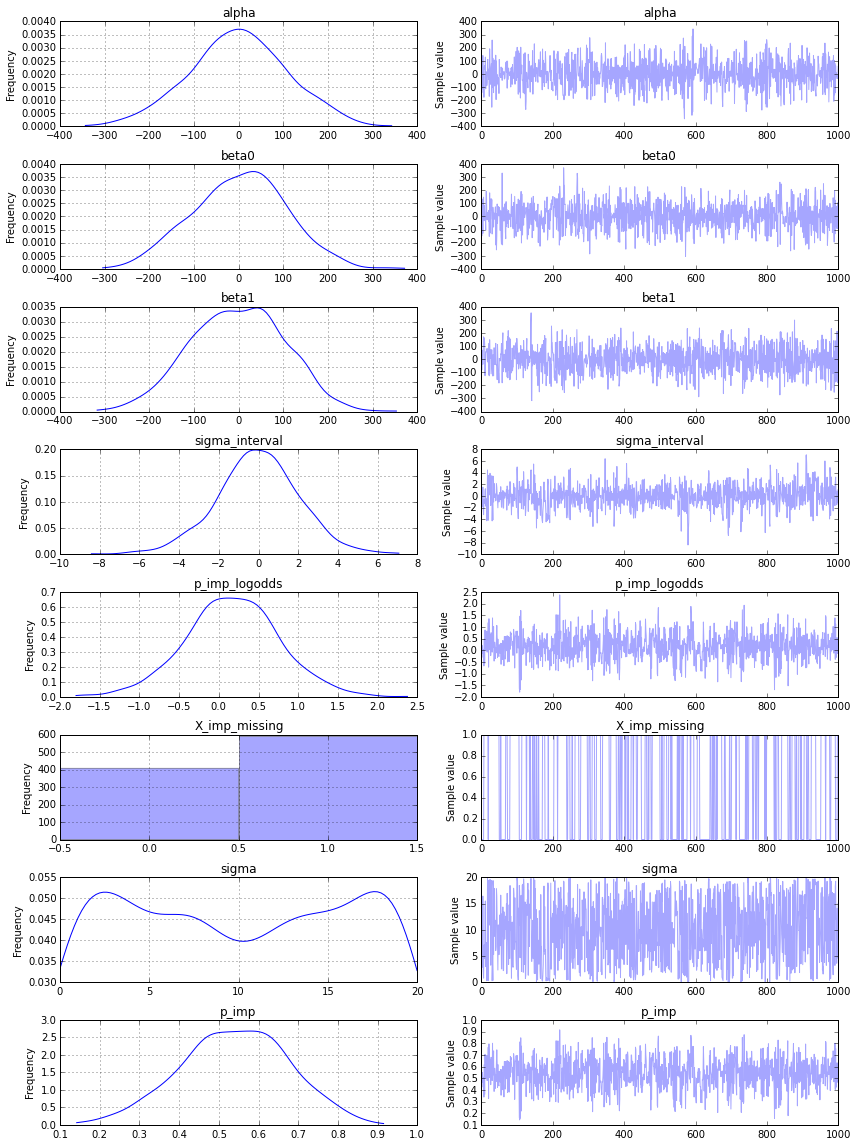

In [23]:

niter = 1000
beta = np.empty(num_p, dtype=object)
X_imp = np.empty(num_p, dtype=object)
basic_model = pm.Model()
with basic_model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=100, shape=1) # Intercept
    for i in range(num_p): # beta0 to betaN
        beta[i] = pm.Normal('beta' + str(i), mu=0, sd=100, shape=1)
    sigma = pm.Uniform('sigma', lower=0, upper=20) # Std
    
    # Imput missing values
    # ???
    # refer to [https://github.com/pymc-devs/pymc3/blob/58f3f8e5d2a55edc5e05b33b239fa46631eff895/pymc3/examples/lasso_missing.py]
    p_imp = pm.Beta('p_imp', 1, 1)
    X_imp = pm.Bernoulli('X_imp', p_imp, observed=np.ma.masked_values(X_masked, value=-999))
    
    # Expected value of outcome
    mu = alpha
    for i in range(num_p):
        mu = mu + beta[i]*X_imp[:,i]
    
    # Likelihood
    #likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=Y)
    
    # Obtaining starting values via MAP
    start = pm.find_MAP()
    
    # Draw samples from posterior
    trace = pm.sample(niter, start=start, random_seed=2015, progressbar=True)
    
    # Ploting samples
    pm.traceplot(trace)
    
    # Test code to check if procedure finished.
    print(dt.datetime.now().time())



And uncommented more lines inclusing likelihood, and this made ton of errors

In [24]:

niter = 1000
beta = np.empty(num_p, dtype=object)
X_imp = np.empty(num_p, dtype=object)
basic_model = pm.Model()
with basic_model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=100, shape=1) # Intercept
    for i in range(num_p): # beta0 to betaN
        beta[i] = pm.Normal('beta' + str(i), mu=0, sd=100, shape=1)
    sigma = pm.Uniform('sigma', lower=0, upper=20) # Std
    
    # Imput missing values
    # ???
    # refer to [https://github.com/pymc-devs/pymc3/blob/58f3f8e5d2a55edc5e05b33b239fa46631eff895/pymc3/examples/lasso_missing.py]
    p_imp = pm.Beta('p_imp', 1, 1)
    X_imp = pm.Bernoulli('X_imp', p_imp, observed=np.ma.masked_values(X_masked, value=-999))
    
    # Expected value of outcome
    mu = alpha
    for i in range(num_p):
        mu = mu + beta[i]*X_imp[:,i]
    
    # Likelihood
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=Y)
    
    # Obtaining starting values via MAP
    start = pm.find_MAP()
    
    # Draw samples from posterior
    trace = pm.sample(niter, start=start, random_seed=2015, progressbar=True)
    
    # Ploting samples
    pm.traceplot(trace)
    
    # Test code to check if procedure finished.
    print(dt.datetime.now().time())



Assigned <class 'pymc3.step_methods.nuts.NUTS'> to alpha
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta0
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta1
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to sigma_interval
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to p_imp_logodds
Assigned <class 'pymc3.step_methods.metropolis.Metropolis'> to X_imp_missing


TypeError: unorderable types: int() > NoneType()

So let's simplify looping to compute likelihood.

I'v just changed for loop to original full summention, and errors are disappeared.

--X--
(6, 2)
(6,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>

--beta--
(2,)
Shape.0
<class 'numpy.ndarray'>
<class 'pymc3.model.FreeRV'>

--mu--
Shape.0
Subtensor{int64}.0
<class 'theano.tensor.var.TensorVariable'>
TensorType(float64, vector)

--Y--
(6,)

Assigned <class 'pymc3.step_methods.nuts.NUTS'> to alpha
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta0
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta1
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to sigma_interval
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to p_imp_logodds
Assigned <class 'pymc3.step_methods.metropolis.Metropolis'> to X_imp_missing
 [-----------------100%-----------------] 1000 of 1000 complete in 2.0 sec23:37:17.246722


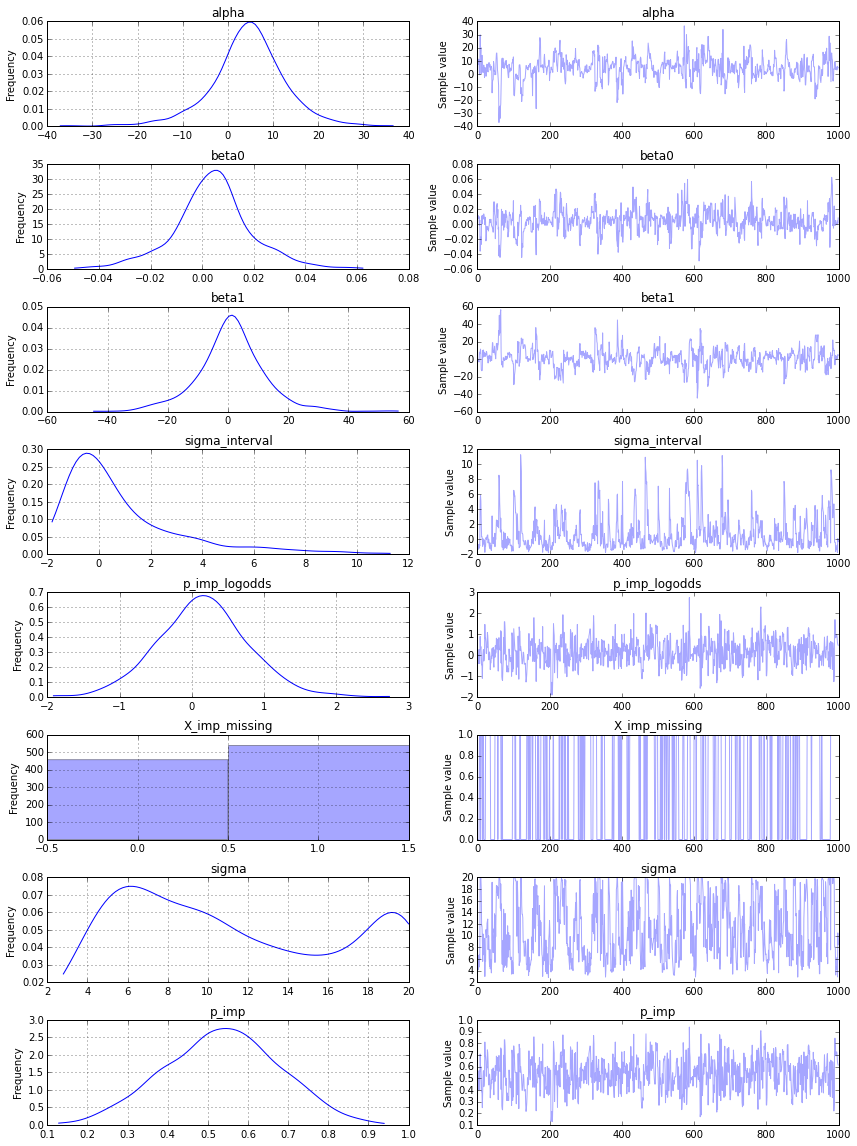

In [11]:

niter = 1000
beta = np.empty(num_p, dtype=object)
X_imp = np.empty(num_p, dtype=object)
basic_model = pm.Model()
with basic_model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=100, shape=1) # Intercept
    for i in range(num_p): # beta0 to betaN
        beta[i] = pm.Normal('beta' + str(i), mu=0, sd=100, shape=1)
    sigma = pm.Uniform('sigma', lower=0, upper=20) # Std
    
    # Imput missing values
    # ???
    # refer to [https://github.com/pymc-devs/pymc3/blob/58f3f8e5d2a55edc5e05b33b239fa46631eff895/pymc3/examples/lasso_missing.py]
    p_imp = pm.Beta('p_imp', 1, 1)
    X_imp = pm.Bernoulli('X_imp', p_imp, observed=np.ma.masked_values(X_masked, value=-999))
    
    # Expected value of outcome
    #mu = alpha + beta[0]*X[:1,0] + beta[1]*X[:1,1]
    mu = alpha + beta[0]*X[:,0] + beta[1]*X[:,1]

    #mu = alpha
    #for i in range(num_p):
    #    mu = mu + beta[i]*X_imp[:,i]
    print("--X--")
    print(X.shape)
    print(X[:,0].shape)
    print(type(X))
    print(type(X[:,0]))
    print("")
    
    print("--beta--")
    print(beta.shape)
    print(beta[0].shape)
    print(type(beta))
    print(type(beta[0]))
    #print(beta.type)
    print("")
    
    print("--mu--")
    print(mu.shape)
    print(mu.shape[0])
    print(type(mu))
    print(mu.type)
    print("")
   
    print("--Y--")
    print(Y.shape)
    print("")
    
    # Likelihood
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=Y)
    
    # Obtaining starting values via MAP
    start = pm.find_MAP()
    
    # Draw samples from posterior
    trace = pm.sample(niter, start=start, random_seed=2015, progressbar=True)
    
    # Ploting samples
    pm.traceplot(trace)
    
    # Test code to check if procedure finished.
    print(dt.datetime.now().time())



So, let's try full summention syntax with simplified original data.

I wanna know what is the [dimension miss-match error]. so tried to find clue from google search for related articles.


Theano [Input dimension mis-match] error.

[http://deeplearning.net/software/theano/tutorial/debug_faq.html]

[http://stackoverflow.com/questions/31080866/theano-function-that-can-take-input-arrays-of-different-shapes-in-python]



theano.function(inputs, outputs, ... )
에서 inputs값은 항상 list이어야만한다.

아래와 같은 상황에서 input dimension miss-match가 발생한다.


In [9]:
import theano
import numpy
theano.config.compute_test_value = 'off'

x = theano.tensor.matrix(dtype=theano.config.floatX)
y = 3*x
f = theano.function([x],y, allow_input_downcast=True)



f(numpy.array([1,2,3]))
#f(numpy.array([[1,2]]))

TypeError: ('Bad input argument to theano function with name "<ipython-input-9-8cd763a77600>:7"  at index 0(0-based)', 'Wrong number of dimensions: expected 2, got 1 with shape (3,).')

이 문제는 아래와 같이 input list를 list of matrix로 바꿔주면 해결된다.

In [12]:
import theano
import numpy
theano.config.compute_test_value = 'off'
#theano.config.allow_input_downcast=True

x = theano.tensor.matrix(dtype=theano.config.floatX)
y = 3*x
f = theano.function([x],y, allow_input_downcast=True)

f(numpy.array([[1,2]]))


array([[ 3.,  6.]], dtype=float32)

이번에는 간단한 for looping 상황을 제현해 보자. (imputation도 잠간 제거 해 본다.)

어이 없게도 imputation을 하지 않으니(X_imp를 사용하지 않으니) 에러가 사라짐..


In [26]:
num_n = 6 #max 144(total 145 rows)
num_p = 2  #max 126(total 127 columns)
Y = np.array([10, 9, 8, 1, 2, 1])
X = np.array([[1,1],[1,0],[1,1],[0,0],[0,1],[1,0]])



In [ ]:
niter = 1000
beta = np.empty(num_p, dtype=object)
basic_model = pm.Model()
with basic_model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=100, shape=1) # Intercept
    for i in range(num_p): # beta0 to betaN
        beta[i] = pm.Normal('beta' + str(i), mu=0, sd=100, shape=1)
    sigma = pm.Uniform('sigma', lower=0, upper=20) # Std
    
    # Expected value of outcome
    mu = alpha
    for i in range(num_p):
        mu = mu + beta[i]*X[:,i]
    #mu = alpha + beta[0]*X[:,0] + beta[1]*X[:,1]
    
 
    # Likelihood
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=Y)
    
    # Obtaining starting values via MAP
    start = pm.find_MAP()
    
    # Draw samples from posterior
    trace = pm.sample(niter, start=start, random_seed=2015, progressbar=True)
    
    # Ploting samples
    pm.traceplot(trace)
    
    # Test code to check if procedure finished.
    print(dt.datetime.now().time())

그렇다면 아마도 X_imp를 사용할때, 즉 empty object?가 theano를 탈 때 문제가 발생하는 것으로 보인다.

그럼.. .다시 X_imp를 사용해 보자.

잠간... for loop를 풀어서 쓰고 있는데, 앞서 테스트에서 X_imp 대신에 X를 사용한 것을 발견 했다. 결국 loop를 쓰든 그렇지 않든 X_imp를 사용할 경우 문제가 발생하는 것이다.

과연 np.empty 이 녀석이 왜 문제를 발생시키는 것이지?

In [27]:
num_n = 6 #max 144(total 145 rows)
num_p = 2  #max 126(total 127 columns)
#Y = np.array([10, 9, 8, 1, 2, 1])
Y = np.array([10, 9, 8, 1, 2, 1])
X = np.array([[1,1],[1,0],[1,1],[0,0],[0,1],[-999,0]])
X_masked = np.ma.masked_array(X, mask=X==-999)

beta = np.empty(num_p, dtype=object)
X_imp = np.empty(num_p, dtype=object)



--X--
(6, 2)
(6,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>

--X_imp--
Shape.0
Shape.0
<class 'pymc3.model.ObservedRV'>
<class 'theano.tensor.var.TensorVariable'>

--beta--
(2,)
Shape.0
<class 'numpy.ndarray'>
<class 'pymc3.model.FreeRV'>

--mu--
Shape.0
Subtensor{int64}.0
<class 'theano.tensor.var.TensorVariable'>
TensorType(float64, vector)

--Y--
(6,)

Assigned <class 'pymc3.step_methods.nuts.NUTS'> to alpha
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta0
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta1
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to sigma_interval
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to p_imp_logodds
Assigned <class 'pymc3.step_methods.metropolis.Metropolis'> to X_imp_missing
 [-----------------100%-----------------] 1000 of 1000 complete in 2.0 sec19:07:39.034977


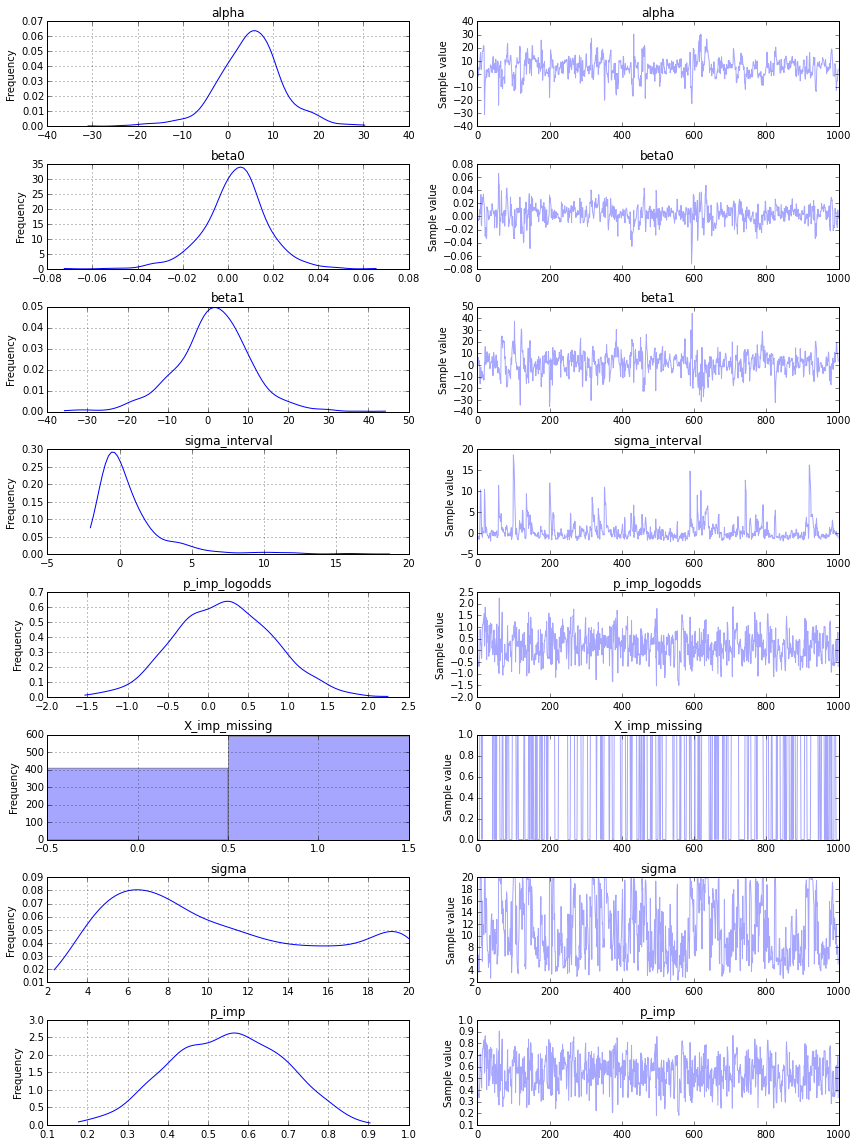

In [28]:

niter = 1000
beta = np.empty(num_p, dtype=object)
X_imp = np.empty(num_p, dtype=object)
basic_model = pm.Model()
with basic_model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=100, shape=1) # Intercept
    for i in range(num_p): # beta0 to betaN
        beta[i] = pm.Normal('beta' + str(i), mu=0, sd=100, shape=1)
    sigma = pm.Uniform('sigma', lower=0, upper=20) # Std
    
    # Imput missing values
    # ???
    # refer to [https://github.com/pymc-devs/pymc3/blob/58f3f8e5d2a55edc5e05b33b239fa46631eff895/pymc3/examples/lasso_missing.py]
    p_imp = pm.Beta('p_imp', 1, 1)
    X_imp = pm.Bernoulli('X_imp', p_imp, observed=np.ma.masked_values(X_masked, value=-999))
    
    # Expected value of outcome
    #mu = alpha + beta[0]*X[:1,0] + beta[1]*X[:1,1]
    mu = alpha + beta[0]*X[:,0] + beta[1]*X[:,1]

    #mu = alpha
    #for i in range(num_p):
    #    mu = mu + beta[i]*X_imp[:,i]
    print("--X--")
    print(X.shape)
    print(X[:,0].shape)
    print(type(X))
    print(type(X[:,0]))
    print("")
    
    print("--X_imp--")
    print(X_imp.shape)
    print(X_imp[:,0].shape)
    print(type(X_imp))
    print(type(X_imp[:,0]))
    print("")
    
    print("--beta--")
    print(beta.shape)
    print(beta[0].shape)
    print(type(beta))
    print(type(beta[0]))
    #print(beta.type)
    print("")
    
    print("--mu--")
    print(mu.shape)
    print(mu.shape[0])
    print(type(mu))
    print(mu.type)
    print("")
   
    print("--Y--")
    print(Y.shape)
    print("")
    
    # Likelihood
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=Y)
    
    # Obtaining starting values via MAP
    start = pm.find_MAP()
    
    # Draw samples from posterior
    trace = pm.sample(niter, start=start, random_seed=2015, progressbar=True)
    
    # Ploting samples
    pm.traceplot(trace)
    
    # Test code to check if procedure finished.
    print(dt.datetime.now().time())



앞 단계에서 살펴보면 beta는 shape (2,)의 ndarray로서 각 element는 pymc3.model.FreeRV이다.   
반면 X_imp는 pymc3.model.ObservedRV 이다.  

X_imp의 imputation을 for-loop로 바꿔보자.

In [30]:
num_n = 6 #max 144(total 145 rows)
num_p = 2  #max 126(total 127 columns)
#Y = np.array([10, 9, 8, 1, 2, 1])
Y = np.array([10, 9, 8, 1, 2, 1])
X = np.array([[1,1],[1,0],[1,1],[0,0],[0,1],[-999,0]])
X_masked = np.ma.masked_array(X, mask=X==-999)

beta = np.empty(num_p, dtype=object)
X_imp = np.empty(num_p, dtype=object)

X_masked[:,1]


masked_array(data = [1 0 1 0 1 0],
             mask = [False False False False False False],
       fill_value = 999999)

In [34]:

niter = 1000
beta = np.empty(num_p, dtype=object)
X_imp = np.empty(num_p, dtype=object)
basic_model = pm.Model()
with basic_model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=100, shape=1) # Intercept
    for i in range(num_p): # beta0 to betaN
        beta[i] = pm.Normal('beta' + str(i), mu=0, sd=100, shape=1)
    sigma = pm.Uniform('sigma', lower=0, upper=20) # Std
    
    # Imput missing values
    # ???
    # refer to [https://github.com/pymc-devs/pymc3/blob/58f3f8e5d2a55edc5e05b33b239fa46631eff895/pymc3/examples/lasso_missing.py]
    p_imp = pm.Beta('p_imp', 1, 1)
    for i in range(num_p):
        X_imp[i] = pm.Bernoulli('X_imp' + str(i), p_imp, observed=np.ma.masked_values(X_masked[:,i], value=-999))
    
    
    # Expected value of outcome
    #mu = alpha + beta[0]*X[:1,0] + beta[1]*X[:1,1]
    #mu = alpha + beta[0]*X[:,0] + beta[1]*X[:,1]
    mu = alpha + beta[0]*X_imp[0] + beta[1]*X_imp[1]

    #mu = alpha
    #for i in range(num_p):
    #    mu = mu + beta[i]*X_imp[:,i]
    print("--X--")
    print(X.shape)
    print(X[:,0].shape)
    print(type(X))
    print(type(X[:,0]))
    print("")
    
    print("--X_imp--")
    print(X_imp.shape)
    print(X_imp[0].shape)
    print(type(X_imp))
    print(type(X_imp[0]))
    print("")
    
    print("--beta--")
    print(beta.shape)
    print(beta[0].shape)
    print(type(beta))
    print(type(beta[0]))
    #print(beta.type)
    print("")
    
    print("--mu--")
    print(mu.shape)
    print(mu.shape[0])
    print(type(mu))
    print(mu.type)
    print("")
   
    print("--Y--")
    print(Y.shape)
    print("")
    
    # Likelihood
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=Y)
    
    # Obtaining starting values via MAP
    start = pm.find_MAP()
    
    # Draw samples from posterior
    trace = pm.sample(niter, start=start, random_seed=2015, progressbar=True)
    
    # Ploting samples
    pm.traceplot(trace)
    
    # Test code to check if procedure finished.
    print(dt.datetime.now().time())



--X--
(6, 2)
(6,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>

--X_imp--
(2,)
Shape.0
<class 'numpy.ndarray'>
<class 'pymc3.model.ObservedRV'>

--beta--
(2,)
Shape.0
<class 'numpy.ndarray'>
<class 'pymc3.model.FreeRV'>

--mu--
Shape.0
Subtensor{int64}.0
<class 'theano.tensor.var.TensorVariable'>
TensorType(float64, vector)

--Y--
(6,)

Assigned <class 'pymc3.step_methods.nuts.NUTS'> to alpha
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta0
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta1
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to sigma_interval
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to p_imp_logodds
Assigned <class 'pymc3.step_methods.metropolis.Metropolis'> to X_imp0_missing
Assigned <class 'pymc3.step_methods.metropolis.Metropolis'> to X_imp1_missing


TypeError: unorderable types: int() < NoneType()

X와 X_imp의 차이를 알아보자.

우선 X의 경우 단순히 ndarray이지만, model내에서 X_imp는 stochastic node임을 알 수 있다.

In [12]:
X = np.array([[1,1],[1,0],[1,1],[0,0],[0,1],[-999,0]])

print(type(X))
print(X.shape)
X[1].dtype

<class 'numpy.ndarray'>
(6, 2)


dtype('int32')

X_imp는 type이 

array([None, None], dtype=object)

로서.. 이를 어찌하나

In [82]:
X_imp = np.empty(num_p, dtype=object)
X_imp = np.empty(num_p, dtype=object)

#print(type(X_imp))
#print(X_imp.shape)
X_imp[:]

array([None, None], dtype=object)

X_imp의 type을 좀더 면밀히 살펴보자.

<class 'numpy.ndarray'>
<class 'pymc3.model.ObservedRV'>
TensorType(int64, matrix)
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to p_imp_logodds
Assigned <class 'pymc3.step_methods.metropolis.Metropolis'> to X_imp__missing
 [-----------------100%-----------------] 1000 of 1000 complete in 0.4 sec

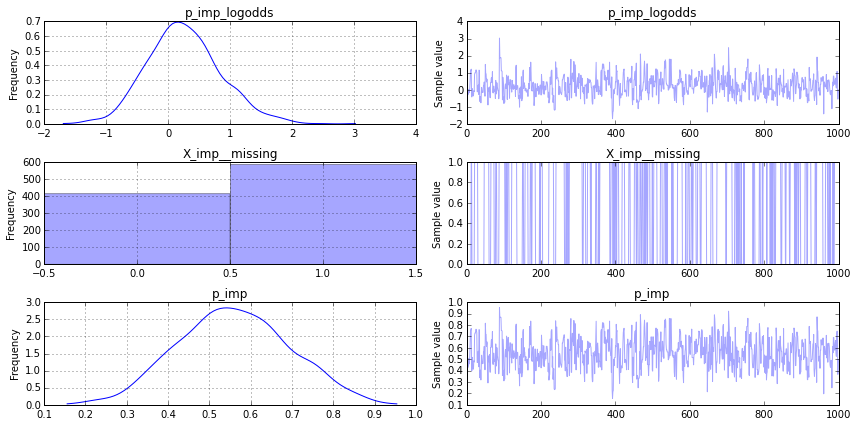

In [77]:
test_model = pm.Model()
with test_model:
    p_imp = pm.Beta('p_imp', 1, 1)
    X_imp = pm.Bernoulli('X_imp_', p_imp, observed=np.ma.masked_values(X_masked, value=-999))
    
    print(type(X))
    print(type(X_imp))
    print(X_imp.type)

with test_model:
    start = pm.find_MAP()
    trace = pm.sample(niter, start=start, random_seed=2015, progressbar=True)
    pm.traceplot(trace)


X_imp의 type이 아래와 같다는데?..

`TensorType(int64, vector)`

`<class 'theano.tensor.var.TensorVariable'>`

그래서?

In [27]:

niter = 1000

basic_model = pm.Model()
with basic_model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=100, shape=1) # Intercept
    for i in range(num_p): # beta0 to betaN
        beta[i] = pm.Normal('beta' + str(i), mu=0, sd=100, shape=1)
    sigma = pm.Uniform('sigma', lower=0, upper=20) # Std
    
    # Imput missing values
    # ???
    # refer to [https://github.com/pymc-devs/pymc3/blob/58f3f8e5d2a55edc5e05b33b239fa46631eff895/pymc3/examples/lasso_missing.py]
    p_imp = pm.Beta('p_imp', 1, 1)
    X_imp = pm.Bernoulli('X_imp_', p_imp, observed=np.ma.masked_values(X_masked, value=-999))
    
    print(X_imp.type)
    print(X_imp.shape)
    print(X_imp.ndim)
    print("")
    print(X_imp[:,0].type)
    print(X_imp[:,0].shape)
    print(X_imp[:,0].ndim)
    
    # Expected value of outcome
    #mu = alpha + beta[0]*X[:1,0] + beta[1]*X[:1,1]
    mu = alpha + beta[0]*X_imp[:,0] + beta[1]*X_imp[:,1]

    #mu = alpha
    #for i in range(num_p):
    #    mu = mu + beta[i]*X_imp[:,i]
    
    # Likelihood
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=Y)
    
'''
with basic_model:
    # Obtaining starting values via MAP
    start = pm.find_MAP()
    
with basic_model:
    # Draw samples from posterior
    trace = pm.sample(niter, start=start, random_seed=2015, progressbar=True)
    
    # Ploting samples
    pm.traceplot(trace)
    
    # Test code to check if procedure finished.
    print(dt.datetime.now().time())
'''
    

TensorType(int64, matrix)
Shape.0
2

TensorType(int64, vector)
Shape.0
1


'\nwith basic_model:\n    # Obtaining starting values via MAP\n    start = pm.find_MAP()\n    \nwith basic_model:\n    # Draw samples from posterior\n    trace = pm.sample(niter, start=start, random_seed=2015, progressbar=True)\n    \n    # Ploting samples\n    pm.traceplot(trace)\n    \n    # Test code to check if procedure finished.\n    print(dt.datetime.now().time())\n'

<class 'theano.tensor.var.TensorVariable'>
TensorType(float32, matrix)
